# Pilot Study  
  
In order to evaluate the effect of global clinical trial pathway (GCT) on the post-market safety events (PMSE), this pilot study uses propensity score matching (PSM) and cox proportional hazard model (Cox). PSM classifies GCT/others with covatiates (i.e. Lag, JStudysize, Orphan, Biologic, ATC and Followup). Cox shows the association with GCT and PMSE.  


## Preprocessing
  

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set_palette('pastel')

In [2]:
# import dataset
pilot = pd.read_csv('./pilot_study.csv',
                    encoding='cp932',
                    parse_dates = [1])

pilot.head(5)

,Ingredient,Approval_date,Days_for_approval,Country,GCT,Lag,Studysize,JStudysize,Orphan,Biologic,FIC,ATC,Event,TimetoEvent
0,コラゲナーゼ（クロストリジウム ヒストリチクム）,2015-07-03,337,US,0,1977.0,1184,102,0,0,1,M,0,1621
1,スクロオキシ水酸化鉄,2015-09-28,313,US,0,670.0,494,494,0,0,0,V,0,1534
2,ルストロンボパグ,2015-09-28,285,JP,0,NaN,220,220,0,0,1,B,0,1534
3,イロプロスト,2015-09-28,277,EU,0,4395.0,406,49,0,0,1,B,0,1534
4,エボロクマブ（遺伝子組み換え）,2016-01-22,308,EU,1,189.0,5115,579,0,1,1,C,0,1418


In [3]:
# check missing values
pilot.isnull().sum()

Ingredient            0
Approval_date         0
Days_for_approval     0
Country               0
GCT                   0
Lag                  37
Studysize             0
JStudysize            0
Orphan                0
Biologic              0
FIC                   0
ATC                   0
Event                 0
TimetoEvent           0
dtype: int64

In [4]:
# create a new column, which stands for Drug_id
pilot['Drug_id'] = range(185)
pilot.Drug_id.head()

0    0
1    1
2    2
3    3
4    4
Name: Drug_id, dtype: int32

In [5]:
# convery days into years
pilot.Lag = pilot.Lag / 365
pilot.TimetoEvent = pilot.TimetoEvent / 365

In [6]:
# fill missing values
pilot['Lag'].fillna(1, inplace = True)
pilot['Lag'].isnull().sum()

0

In [7]:
# create a new column, which stands for proportion of JStudysize
pilot['Pr_JStudysize'] = pilot.JStudysize / pilot.Studysize

In [8]:
# create a new column, which extracts the year in each Ingredient's Approval_date
import datetime
pilot['Approval_year'] = pilot.Approval_date.dt.year
pilot['Approval_year'] = pilot.Approval_year.astype('category')

pilot.Approval_year.dtype

CategoricalDtype(categories=[2011, 2012, 2013, 2014, 2015, 2016], ordered=False)

In [9]:
# drop Approval_date column
pilot.drop('Approval_date',
           axis = 1,
           inplace = True)

In [10]:
# categolize Country
pilot['Country'] = pilot.Country.astype('category')

pilot.Country.dtype

CategoricalDtype(categories=['EU', 'JP', 'US'], ordered=False)

In [11]:
# create a new column, which categorizes ATC
def atc_cate(x) :
    if x == 'J' :
        return 'J'
    elif x == 'L' :
        return 'L'
    else :
        return 'others'

pilot['ATC'] = pilot.ATC.apply(atc_cate)
pilot.ATC.value_counts()

others    115
L          54
J          16
Name: ATC, dtype: int64

## Expolatory Data Analysis (EDA)

### Lag

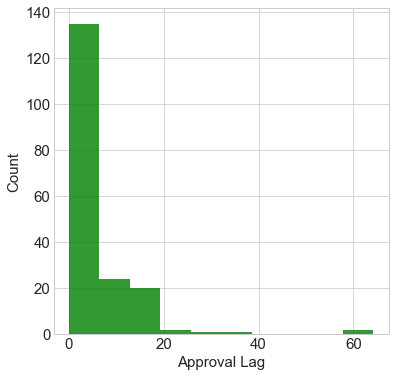

In [12]:
# check the distribution of Lag
plt.figure(figsize = (6, 6))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot.Lag,
             bins = 10,
             alpha = 0.8,
             color = 'green')
_ = plt.xlabel('Approval Lag')
_ = plt.ylabel('Count')

plt.show()

In [13]:
# convert Lag into log-scale Lag
pilot['Lag_log'] = pilot.Lag.apply(np.log10)

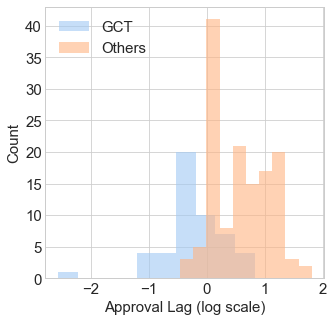

In [14]:
# check the distributions of Lag_log
plt.figure(figsize = (5, 5))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot.query('GCT == 1').Lag_log,
             bins = 10,
             alpha = 0.6)
_ = plt.hist(pilot.query('GCT == 0').Lag_log,
             bins = 10,
             alpha = 0.6)
_ = plt.xlabel('Approval Lag (log scale)')
_ = plt.ylabel('Count')
_ = plt.legend(['GCT', 'Others'])

plt.show()

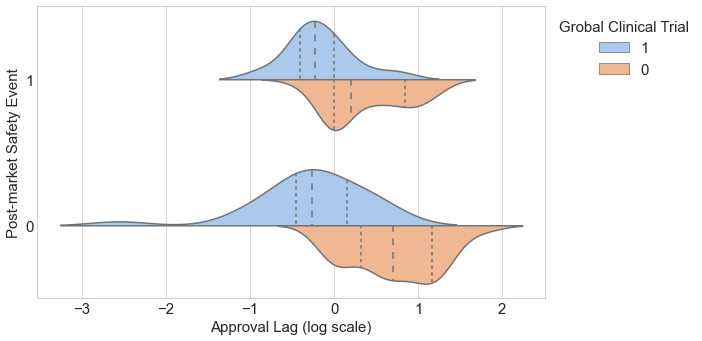

In [15]:
# plot the relationship between Lag_log and PMSE
plt.figure(figsize = (10, 5))

_ = sns.violinplot(x='Lag_log',
                   y='Event',
                   data = pilot,
                   orient = 'horizontal',
                   order = [1, 0],
                   hue = 'GCT',
                   hue_order = [1, 0],
                   split = True,
                   inner = 'quartile',
                   legend = False)
_ = plt.xlabel('Approval Lag (log scale)')
_ = plt.ylabel('Post-market Safety Event')
_ = plt.legend(title = 'Grobal Clinical Trial',
               loc='upper left',
               bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

### JStudysize

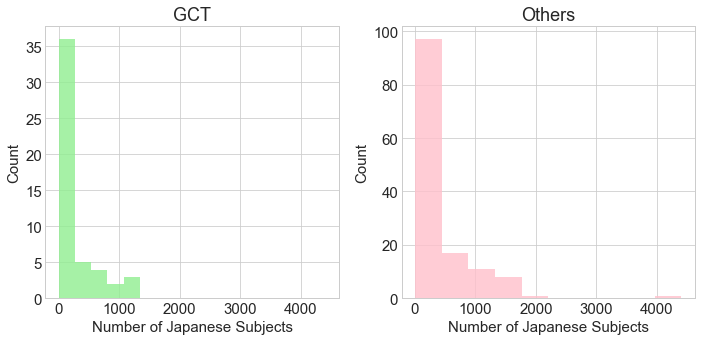

In [16]:
# check the distributions of JStudysize
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(1, 2,
                       sharex = True,
                       figsize = (10, 5))

ax[0].hist(pilot.query('GCT == 1').JStudysize,
           bins = 5,
           alpha = 0.8,
           color = 'lightgreen')
ax[1].hist(pilot.query('GCT == 0').JStudysize,
           bins = 10,
           alpha = 0.8,
           color = 'pink')

titles = ['GCT', 'Others']
for i in range(2) :
    ax[i].set_xlabel('Number of Japanese Subjects')
    ax[i].set_ylabel('Count')
    ax[i].set_title(titles[i])
plt.tight_layout()

plt.show()

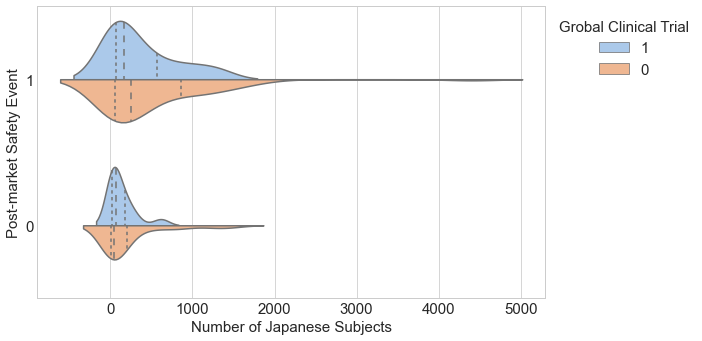

In [17]:
# plot the relationship between JStudysize and PMSE
plt.figure(figsize = (10, 5))

_ = sns.violinplot(x='JStudysize',
                   y='Event',
                   data = pilot,
                   orient = 'horizontal',
                   order = [1, 0],
                   hue = 'GCT',
                   hue_order = [1, 0],
                   split = True,
                   inner = 'quartile',
                   legend = False)
_ = plt.xlabel('Number of Japanese Subjects')
_ = plt.ylabel('Post-market Safety Event')
_ = plt.legend(title = 'Grobal Clinical Trial',
               loc='upper left',
               bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

### Pr_JStudysize

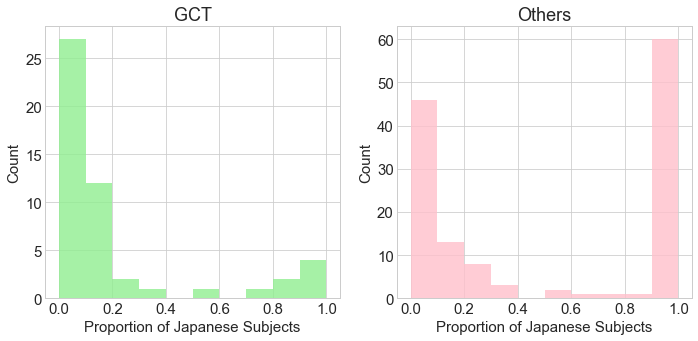

In [18]:
# check the distributions of Pr_JStudysize
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(1, 2,
                       sharex = True,
                       figsize = (10, 5))

ax[0].hist(pilot.query('GCT == 1').Pr_JStudysize,
           bins = 10,
           alpha = 0.8,
           color = 'lightgreen')
ax[1].hist(pilot.query('GCT == 0').Pr_JStudysize,
           bins = 10,
           alpha = 0.8,
           color = 'pink')
labels = ['GCT', 'Others']
for i in range(2) :
    ax[i].set_xlabel('Proportion of Japanese Subjects')
    ax[i].set_ylabel('Count')
    ax[i].set_title(titles[i])

plt.tight_layout()

plt.show()

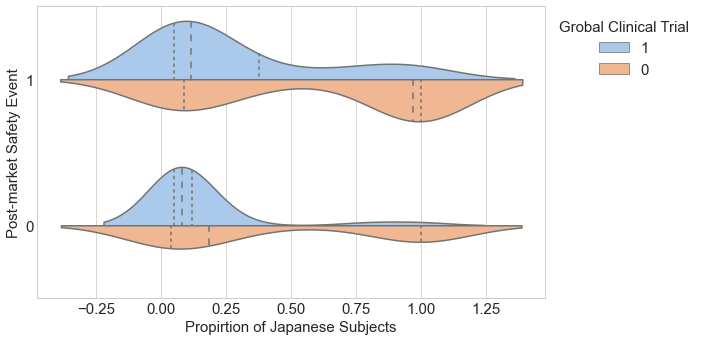

In [19]:
# plot the relationship between Pr_JStudysize and PMSE
plt.figure(figsize = (10, 5))

_ = sns.violinplot(x='Pr_JStudysize',
                   y='Event',
                   data = pilot,
                   orient = 'horizontal',
                   order = [1, 0],
                   hue = 'GCT',
                   hue_order = [1, 0],
                   split = True,
                   inner = 'quartile',
                   legend = False)
_ = plt.xlabel('Propirtion of Japanese Subjects')
_ = plt.ylabel('Post-market Safety Event')
_ = plt.legend(title = 'Grobal Clinical Trial',
               loc='upper left',
               bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


In [20]:
# create a new column, which categorizes PR_JStudysize
def js_cate(x) :
    if x <= 0.50 :
        return 0
    else :
        return 1

pilot['Pr_JS_binom'] = pilot['Pr_JStudysize'].apply(js_cate)

In [21]:
# create a crosstab of Pr_JS_binom and PMSE
ct_js_pmse = pd.crosstab(pilot.Pr_JS_binom,
                         pilot.Event)
display(ct_js_pmse)

# create a crosstab of Pr_JS_binom and GCT
ct_js_gct = pd.crosstab(pilot.Pr_JS_binom,
                        pilot.GCT)
display(ct_js_gct)

Event,0,1
Pr_JS_binom,,
0,66,46
1,31,42


GCT,0,1
Pr_JS_binom,,
0,70,42
1,65,8


### Country

In [22]:
# create a crosstab of Country and PMSE
ct_country_pmse = pd.crosstab(pilot.Country,
                              pilot.Event)
display(ct_country_pmse)

Event,0,1
Country,,
EU,19,10
JP,14,24
US,64,54


### Orphan

In [23]:
# create a crosstab of Orphan and PMSE
ct_orphan_pmse = pd.crosstab(pilot.Orphan,
                             pilot.Event)
display(ct_orphan_pmse)

# create a crosstab of Biologic and GCT
ct_orphan_gct = pd.crosstab(pilot.Orphan,
                            pilot.GCT)
display(ct_orphan_gct)

Event,0,1
Orphan,,
0,61,66
1,36,22


GCT,0,1
Orphan,,
0,92,35
1,43,15


### Drag Class (Biologics)

In [24]:
# create a crosstab of Biologic and PMSE
ct_bio_pmse = pd.crosstab(pilot.Biologic,
                          pilot.Event)
display(ct_bio_pmse)

# create a crosstab of Biologic and GCT
ct_bio_gct = pd.crosstab(pilot.Biologic,
                         pilot.GCT)
display(ct_bio_gct)

Event,0,1
Biologic,,
0,73,78
1,24,10


GCT,0,1
Biologic,,
0,114,37
1,21,13


### First-in-class (FIC)

In [25]:
# create a crosstab of FIC and PMSE
ct_fic_pmse = pd.crosstab(pilot.FIC,
                          pilot.Event)
display(ct_fic_pmse)

# create a crosstab of FIC and GCT
ct_fic_gct = pd.crosstab(pilot.FIC,
                         pilot.GCT)
display(ct_fic_gct)

Event,0,1
FIC,,
0,43,51
1,54,37


GCT,0,1
FIC,,
0,62,32
1,73,18


### Therapeutic Area (ATC)

In [26]:
# create a crosstab of ATC and PMSE
ct_atc_pmse = pd.crosstab(pilot.ATC,
                          pilot.Event)
display(ct_atc_pmse)

# create a crosstab of ATC and GCT
ct_atc_gct = pd.crosstab(pilot.ATC,
                         pilot.GCT)
display(ct_atc_gct)

Event,0,1
ATC,,
J,4,12
L,25,29
others,68,47


GCT,0,1
ATC,,
J,14,2
L,39,15
others,82,33


### Approval Year

In [27]:
# create a crosstab of Approval_year and PMSE
ct_app_pmse = pd.crosstab(pilot.Approval_year,
                          pilot.Event)
display(ct_app_pmse)

# create a crosstab of Approval_year and GCT
ct_app_gct = pd.crosstab(pilot.Approval_year,
                         pilot.GCT)
display(ct_app_gct)

Event,0,1
Approval_year,,
2011,8,12
2012,17,22
2013,13,12
2014,28,26
2015,18,13
2016,13,3


GCT,0,1
Approval_year,,
2011,17,3
2012,32,7
2013,19,6
2014,38,16
2015,22,9
2016,7,9


In [28]:
# create a new column, which categorizes Approval_year
def app_cate(x) :
    if x == 2011 :
        return 0
    elif x == 2012 :
        return 0
    elif x == 2013 :
        return 0
    else :
        return 1

pilot['Post_2014'] = pilot['Approval_year'].apply(app_cate)

In [29]:
# create a crosstab of Post_2014 and PMSE
ct_post_pmse = pd.crosstab(pilot.Post_2014,
                           pilot.Event)
display(ct_post_pmse)

# create a crosstab of Post_2014 and GCT
ct_post_gct = pd.crosstab(pilot.Post_2014,
                          pilot.GCT)
display(ct_post_gct)

Event,0,1
Post_2014,,
0,38,46
1,59,42


GCT,0,1
Post_2014,,
0,68,16
1,67,34


In [30]:
# check the dataset after modifications
pilot.head()

,Ingredient,Days_for_approval,Country,GCT,Lag,Studysize,JStudysize,Orphan,Biologic,FIC,ATC,Event,TimetoEvent,Drug_id,Pr_JStudysize,Approval_year,Lag_log,Pr_JS_binom,Post_2014
0,コラゲナーゼ（クロストリジウム ヒストリチクム）,337,US,0,5.416438,1184,102,0,0,1,others,0,4.441096,0,0.086149,2015,0.733714,0,1
1,スクロオキシ水酸化鉄,313,US,0,1.835616,494,494,0,0,0,others,0,4.202740,1,1.000000,2015,0.263782,1,1
2,ルストロンボパグ,285,JP,0,1.000000,220,220,0,0,1,others,0,4.202740,2,1.000000,2015,0.000000,1,1
3,イロプロスト,277,EU,0,12.041096,406,49,0,0,1,others,0,4.202740,3,0.120690,2015,1.080666,0,1
4,エボロクマブ（遺伝子組み換え）,308,EU,1,0.517808,5115,579,0,1,1,others,0,3.884932,4,0.113196,2016,-0.285831,0,1


## Caluculate Propensity Score (PS)  
Based on EDA, the Propensity Score (i.e. the probability of the allocation to GCT) is caluculated by using Random Forest with the following covariates :
'Lag_log', 'Pr_JS_binom', 'Country', 'Orphan', 'FIC', 'ATC', 'Approval_year_binom'  

In [31]:
# create dataset for caluculating PS
calculate_ps_full = pilot[['Drug_id', 'GCT', 'Lag_log', 'Pr_JS_binom', 'Country', 'Orphan', 'FIC', 'ATC', 'Approval_year', 'Post_2014', 'Event', 'TimetoEvent']]

In [32]:
# remove data whose Approval_year is 2016
calculate_ps = calculate_ps_full.query('Approval_year != 2016')
calculate_ps.Approval_year.value_counts()

2014    54
2012    39
2015    31
2013    25
2011    20
2016     0
Name: Approval_year, dtype: int64

In [33]:
# drop Approval_year
calculate_ps.drop('Approval_year',
                   axis = 1,
                   inplace = True)

In [34]:
# get_dummies
calculate_ps = pd.get_dummies(calculate_ps)

calculate_ps.head()

,Drug_id,GCT,Lag_log,Pr_JS_binom,Orphan,FIC,Post_2014,Event,TimetoEvent,Country_EU,Country_JP,Country_US,ATC_J,ATC_L,ATC_others
0,0,0,0.733714,0,0,1,1,0,4.441096,0,0,1,0,0,1
1,1,0,0.263782,1,0,0,1,0,4.202740,0,0,1,0,0,1
2,2,0,0.000000,1,0,1,1,0,4.202740,0,1,0,0,0,1
3,3,0,1.080666,0,0,1,1,0,4.202740,1,0,0,0,0,1
5,5,0,1.253418,1,0,0,1,0,4.202740,0,0,1,0,0,1


In [35]:
# # save datasets as csv
# calculate_ps_full.to_csv('./calculate_ps_full.csv',
#                          index = False)

# calculate_ps.to_csv('./calculate_ps.csv',
#                      index = False)